<a href="https://colab.research.google.com/github/Borja-rg/idal_ia3/blob/main/Smoke_classification_(Attempts).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://static.casadomo.com/media/2020/02/lonmark-espana-universidad-valencia-jornada-automatizacion.png" align="right" style="float" width="300">


# **WILDFIRE SMOKE CLASSIFICATION**
##**(Attempts with Full Images)**

### Borja Ramón Gómez 

En este notebook se ha intentado analizar fotografías completas de bosques con humo causado por un incendio, provenientes del Wildfire Smoke Dataset. El objetivo es diseñar una CNN capaz de clasificar las imágenes en función de si tienen humo o no. A continuación constan los distintos pasos e intentos realizadas:

1.   Importación y preparación de los datos de entrenamiento, validación y testeo.
2.   Intento I: Diseño de una CNN propia.
3.   Intento II: Transfer Learning (EfficientNet)



In [1]:
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Importación y Preparación de Datos**

A continuación se importan las imágenes utilizadas. 1336 imágenes divididas casi equitativamente entre la clase Humo y No Humo, son repartidas entre los conjuntos de entrenamiento, validación y testeo con unos ratios de 70%, 20% y 10% respectivamente.

In [ ]:
!unzip drive/MyDrive/SMOKE/challenge1.zip

In [ ]:
smoke = glob('challenge1/smoke/*jpg')
no_smoke = glob('challenge1/no_smoke/*jpg')
random.shuffle(smoke)
random.shuffle(no_smoke)
train_ratio = 0.7
val_ratio = 0.2

num_smoke = len(smoke)
num_nosmoke = len(no_smoke)

train_smoke = smoke[:round(train_ratio*num_smoke)]
train_nosmoke = no_smoke[:round(train_ratio*num_nosmoke)]

val_smoke = smoke[round(train_ratio*num_smoke):round((train_ratio+val_ratio)*num_smoke)]
val_nosmoke = no_smoke[round(train_ratio*num_nosmoke):round((train_ratio+val_ratio)*num_nosmoke)]

test_smoke = smoke[round((train_ratio+val_ratio)*num_smoke):]
test_nosmoke = no_smoke[round((train_ratio+val_ratio)*num_nosmoke):]

train_X = train_smoke + train_nosmoke
train_y = len(train_smoke) * ['Smoke'] + len(train_nosmoke)*['No smoke']

val_X = val_smoke + val_nosmoke
val_y = len(val_smoke) * ['Smoke'] + len(val_nosmoke)*['No smoke']

test_X = test_smoke + test_nosmoke
test_y = len(test_smoke) * ['Smoke'] + len(test_nosmoke)*['No smoke']

df_train = pd.DataFrame(columns=['filepath','class'])
df_train['filepath'] = train_X
df_train['class'] = train_y

df_val = pd.DataFrame(columns=['filepath','class'])
df_val['filepath'] = val_X
df_val['class'] = val_y

df_test = pd.DataFrame(columns=['filepath','class'])
df_test['filepath'] = test_X
df_test['class'] = test_y

In [ ]:
tot = len(smoke)+len(no_smoke)
print(f'Number of total images: \nSmoke = {len(smoke)} ({round(len(smoke)/tot*100,2)} %)\nNo smoke = {len(no_smoke)} ({round(len(no_smoke)/tot*100,2)} %)')
print(f'Ratios: Train 70%, Validation 20%, Test 10%')

Number of total images: 
Smoke = 713 (53.37 %)
No smoke = 623 (46.63 %)
Ratios: Train 70%, Validation 20%, Test 10%


Con el objetivo de no cargar todas las imágenes a memoria, se crea un generador para cada set de datos que introduce progresivamente los datos en batches. Se ha decidido realizar data augmentation para el conjunto de entrenamiento, dada la reducida cantidad de datos disponibles. Merece la pena mencionar que las imágenes son de una alta resolución, 1536 x 2048.

In [ ]:
batch_size = 4

train_gen = ImageDataGenerator(dtype='float32',
                              preprocessing_function = lambda x:x/255,
                              rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              fill_mode='nearest',
                              shear_range=0.1,
                              zoom_range=0.2,
                              horizontal_flip=True)

val_gen  = ImageDataGenerator(dtype='float32', preprocessing_function = lambda x:x/255)

test_gen = ImageDataGenerator(dtype='float32', preprocessing_function = lambda x:x/255)

In [ ]:
sizes = {}
for i in range(len(train_nosmoke)):
  im = train_nosmoke[i]
  image = load_img(im)
#  display(image)
  size = np.array(image).shape
  if size not in sizes:
    sizes[size] = 1
  else:
    sizes[size] += 1
sizes

{(1536, 2048, 3): 240, (2048, 3072, 3): 196}

In [3]:
target_size = (1536, 2048)
input_shape = (1536, 2048, 3)

In [ ]:
train_generator = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

val_generator = val_gen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 935 validated image filenames belonging to 2 classes.
Found 268 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.


## 2. Diseño y Entrenamiento de CNN

En esta sección se diseña una red convolucional y se obtiene su rendimiento.

In [8]:
dropout = 0.5
regul = 'l2'
optimizer = 'adam'

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',input_shape=input_shape))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(dropout))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(dropout))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(GlobalAveragePooling2D())

model.add(Dropout(dropout))
model.add(Dense(128, activation='relu',kernel_regularizer = regul))
model.add(Dropout(dropout))
model.add(Dense(64, activation='relu',kernel_regularizer = regul))
model.add(Dropout(dropout))
model.add(Dense(16, activation='relu',kernel_regularizer = regul))
model.add(Dropout(dropout))
model.add(Dense(2))
model.add(Activation('softmax')) 
model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 5
modelpath="best_model.h5"
callback = [ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max')]

In [ ]:
history = model.fit(train_generator,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callback,
                    validation_data = val_generator
                    )

Epoch 1/5
234/234 [==============================] - 855s 4s/step - loss: 1.3819 - accuracy: 0.4680 - val_loss: 0.7989 - val_accuracy: 0.5336

Epoch 00001: val_accuracy improved from -inf to 0.53358, saving model to best_model.h5
Epoch 2/5
234/234 [==============================] - 830s 4s/step - loss: 0.7671 - accuracy: 0.5184 - val_loss: 0.7101 - val_accuracy: 0.5336

Epoch 00002: val_accuracy did not improve from 0.53358
Epoch 3/5
234/234 [==============================] - 837s 4s/step - loss: 0.7054 - accuracy: 0.5296 - val_loss: 0.6957 - val_accuracy: 0.5336

Epoch 00003: val_accuracy did not improve from 0.53358
Epoch 4/5
234/234 [==============================] - 839s 4s/step - loss: 0.6963 - accuracy: 0.5269 - val_loss: 0.6926 - val_accuracy: 0.5336

Epoch 00004: val_accuracy did not improve from 0.53358
Epoch 5/5
234/234 [==============================] - 823s 4s/step - loss: 0.6925 - accuracy: 0.5326 - val_loss: 0.6916 - val_accuracy: 0.5336

Epoch 00005: val_accuracy did not

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(val_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

30/30 [==============================] - 59s 2s/step - loss: 0.7129 - accuracy: 0.5337
Train loss    : 0.7129409313201904
Train accuracy: 0.5336898565292358

9/9 [==============================] - 14s 2s/step - loss: 0.7130 - accuracy: 0.5336
Val loss    : 0.7129531502723694
Val accuracy: 0.5335820913314819

5/5 [==============================] - 7s 1s/step - loss: 0.7129 - accuracy: 0.5338
Test loss     : 0.7129253149032593
Test accuracy : 0.5338345766067505


Este mismo procedimiento se ha intentado para distintos parámetros de dropout, tamaño del batch, regularizaciones y número de capas. Para todos los casos se ha obtenido que la red no es capaz de obtener información a partir de las fotografías, ya que la accuracy es del 0.53. 

Esto probablemente se deba al gran tamaño de las fotografías de entrada en comparación con el humo. Por ello, se necesitaría una red más profunda y adaptada a entradas grandes, lo cual se va a intentar con Transfer Learning.

## 3. Transfer Learning: Red EfficientNetB7

En este apartado se utiliza la red convolucional llamada EfficientNetB7, la cual ha sido escogida por haber sido entrenada para el mayor tamaño de entrada de las disponibles en keras applications, 600 x 600.

Esta red se utiliza para diseñar 3 redes distintas y comprobar su eficacia.

In [ ]:
input_shape_tl = (2400,2400,3)

In [ ]:
from tensorflow.keras.applications import Xception, VGG16, ResNet50, VGG19, EfficientNetB7

In [ ]:
efficient = EfficientNetB7(weights='imagenet', include_top = False)
efficient_2 = EfficientNetB7(weights = 'imagenet', include_top=False,input_shape = (600,600,3))

258080768/258076736 [==============================] - 6s 0us/step


In [ ]:
efficient.trainable = False
efficient.summary()

La primera approximación utilizando la EfficientNet consta de modificar todas las imágenes de entrada a un tamaño de 2400 x 2400. Esto se hace para añadir dos capas convolucionales y max pooling antes del modelo para reducir las entradas a 600 x 600. Tras concatenar el modelo, se añaden unas capas densas a la salida. Finalmente se entrenan las capas nuevas, dejando el modelo Efficient con los pesos originales.

In [ ]:
my_submodel = Sequential()
my_submodel.add(Conv2D(3,(3,3),padding='same',input_shape = input_shape_tl))
my_submodel.add(MaxPooling2D((2,2)))
my_submodel.add(Conv2D(3,(3,3),padding='same'))
my_submodel.add(MaxPooling2D((2,2)))
my_submodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 2400, 2400, 3)     84        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1200, 1200, 3)     0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1200, 1200, 3)     84        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 600, 600, 3)       0         
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________


In [ ]:
efficient.trainable=False
x = my_submodel.output
out = efficient(x)
global_avg = GlobalAveragePooling2D()(out)
dense_01 = keras.layers.Dense(units=256,activation="relu")(global_avg)
drop = keras.layers.Dropout(0.5)(dense_01)
dense_02 = keras.layers.Dense(units=64,activation="relu")(drop)
drop2 = keras.layers.Dropout(0.5)(dense_02)
dense_02 = keras.layers.Dense(2)(drop2)
act = keras.layers.Activation('softmax')(dense_02)
tot_model = Model(my_submodel.input, act)
tot_model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
tot_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30_input (InputLayer) [(None, 2400, 2400, 3)]   0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 2400, 2400, 3)     84        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1200, 1200, 3)     0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1200, 1200, 3)     84        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 600, 600, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2560)              0  

In [ ]:
target_size = (2400,2400)
batch_size = 2

In [ ]:
train_generator_tl = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

val_generator_tl = val_gen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator_tl = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 935 validated image filenames belonging to 2 classes.
Found 268 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.


In [ ]:
for batch in test_generator_tl:
  im = batch[0][31]
  plt.imshow(im)
  break

In [ ]:
history_tl = tot_model.fit(train_generator_tl,
             batch_size = batch_size,
             epochs = 2,
             validation_data = val_generator_tl
             )

Epoch 1/2
468/468 [==============================] - 1527s 3s/step - loss: 0.8723 - accuracy: 0.4845 - val_loss: 0.6911 - val_accuracy: 0.5336
Epoch 2/2
468/468 [==============================] - 1497s 3s/step - loss: 0.7151 - accuracy: 0.5316 - val_loss: 0.6911 - val_accuracy: 0.5336


In [ ]:
scores_tr = tot_model.evaluate(train_generator_tl)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = tot_model.evaluate(val_generator_tl)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = tot_model.evaluate(test_generator_tl)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

468/468 [==============================] - 1219s 3s/step - loss: 0.6911 - accuracy: 0.5337
Train loss    : 0.6910744905471802
Train accuracy: 0.5336898565292358

134/134 [==============================] - 48s 357ms/step - loss: 0.6910 - accuracy: 0.5336
Val loss    : 0.6909761428833008
Val accuracy: 0.5335820913314819

67/67 [==============================] - 24s 354ms/step - loss: 0.6912 - accuracy: 0.5338
Test loss     : 0.6912146210670471
Test accuracy : 0.5338345766067505


El segundo acercamiento utilizando la red EfficientNet consta de retirar las capas convolucionales iniciales y dejar que los propios generaciones reduzcan las imágenes de entrada al tamaño de entrada de la red, 600 x 600.

In [ ]:
target_size_2 = (600,600)
batch_size = 8

train_generator_tl_2 = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size_2,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

val_generator_tl_2 = val_gen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size_2,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator_tl_2 = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size_2,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 935 validated image filenames belonging to 2 classes.
Found 268 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.


In [ ]:
efficient_2.trainable=False
x = efficient_2.output
global_avg = GlobalAveragePooling2D()(x)
dense_01 = keras.layers.Dense(units=256,activation="relu")(global_avg)
drop = keras.layers.Dropout(0.5)(dense_01)
dense_02 = keras.layers.Dense(units=64,activation="relu")(drop)
drop2 = keras.layers.Dropout(0.5)(dense_02)
dense_02 = keras.layers.Dense(2)(drop2)
act = keras.layers.Activation('softmax')(dense_02)
tot_model_2 = Model(efficient_2.input, act)
tot_model_2.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
tot_model_2.summary()

In [ ]:
history_tl_2 = tot_model_2.fit(train_generator_tl_2,
             batch_size = batch_size,
             epochs = 4,
             validation_data = val_generator_tl_2
             )

Epoch 1/4
117/117 [==============================] - 191s 1s/step - loss: 0.8578 - accuracy: 0.5196 - val_loss: 0.6910 - val_accuracy: 0.5336
Epoch 2/4
117/117 [==============================] - 173s 1s/step - loss: 0.7022 - accuracy: 0.5186 - val_loss: 0.6925 - val_accuracy: 0.5336
Epoch 3/4
117/117 [==============================] - 169s 1s/step - loss: 0.6937 - accuracy: 0.4957 - val_loss: 0.6918 - val_accuracy: 0.5336
Epoch 4/4
117/117 [==============================] - 169s 1s/step - loss: 0.6898 - accuracy: 0.5668 - val_loss: 0.6912 - val_accuracy: 0.5336


In [ ]:
scores_tr = tot_model_2.evaluate(train_generator_tl_2)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = tot_model_2.evaluate(val_generator_tl_2)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = tot_model_2.evaluate(test_generator_tl_2)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

117/117 [==============================] - 148s 1s/step - loss: 0.6912 - accuracy: 0.5337
Train loss    : 0.6911768913269043
Train accuracy: 0.5336898565292358

34/34 [==============================] - 25s 723ms/step - loss: 0.6912 - accuracy: 0.5336
Val loss    : 0.6911858916282654
Val accuracy: 0.5335820913314819

17/17 [==============================] - 14s 779ms/step - loss: 0.6912 - accuracy: 0.5338
Test loss     : 0.6911644339561462
Test accuracy : 0.5338345766067505


In [ ]:
def get_roc(models, test_gens, pos_class=1):
  y_real = np.array(test_gens[0].classes)
  fig, ax1 = plt.subplots(1,1)
  ax1.set_xlabel('False Positive Rate')
  ax1.set_ylabel('True Positive Rate')
  aspect = ['r--','g--','m--','c--','ro-','go-','c--','m--']
  aucs = []
  for i in range(len(models)):
    model = models[i]
    c = aspect[i]
    y_pred_proba = model.predict(test_gens[i])
    fpr, tpr, thresholds = roc_curve(y_real==pos_class, y_pred_proba[:,pos_class])
    au = auc(fpr, tpr)
    ax1.plot(fpr, tpr, c , label = f'CNN {i+1} ({au:.2f})')
    aucs.append(au)
  ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
  ax1.legend();
  plt.show()
  return aucs

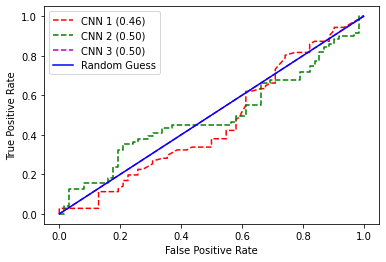

In [ ]:
aucs = get_roc([model,tot_model,tot_model_2],[test_generator,test_generator_tl,test_generator_tl_2])

Representando las curvas roc de cada uno de los modelos, se puede observar claramente que ninguno de ellos es util para obtener información de las imágenes de entrada. A continuación se ha probado a sustituir las capas densas por un Support Vector Classifier, sin obtener ningún resultado.

In [ ]:
from sklearn.svm import SVC

In [ ]:
efficient_2.trainable=False
global_avg = GlobalAveragePooling2D()(efficient_2.output)
svm = Model(inputs = efficient_2.input, outputs = global_avg)
svm.compile()

In [ ]:
target_size_2 = (600,600)
batch_size = 1

train_generator_tl_3 = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size_2,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

val_generator_tl_3 = val_gen.flow_from_dataframe(
    dataframe=df_val,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size_2,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator_tl_3 = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col = "filepath",
    y_col = "class",
    target_size = target_size_2,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 935 validated image filenames belonging to 2 classes.
Found 268 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.


In [ ]:
features_train = svm.predict(train_generator_tl_3)
features_val = svm.predict(val_generator_tl_3)
features_test = svm.predict(test_generator_tl_3)

In [ ]:
feat_train_df = pd.DataFrame(features_train)
feat_train_df['labels'] = train_generator_tl_3.labels

feat_val_df = pd.DataFrame(features_val)
feat_val_df['labels'] = val_generator_tl_3.labels

feat_test_df = pd.DataFrame(features_test)
feat_test_df['labels'] = test_generator_tl_3.labels

In [ ]:
X_train = feat_train_df.iloc[:,:-1]
Y_train = feat_train_df.iloc[:,-1]

X_val = feat_val_df.iloc[:,:-1]
Y_val = feat_val_df.iloc[:,-1]

X_test = feat_test_df.iloc[:,:-1]
Y_test = feat_test_df.iloc[:,-1]

In [ ]:
model_ml = SVC(C=0.8)
model_ml.fit(X_train,Y_train)

SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
model_ml.score(X_train, Y_train)

0.5336898395721925

In [ ]:
model_ml.score(X_test, Y_test)

0.5338345864661654

## Visualización de la red

Finalmente, se ha diseñado un pequeño código para poder visualizar las salidas de cada capa de la red, observando que salen mayormente negras. Esto concuerda con el hecho de que no obtengan información.

In [ ]:
batch=30
n = 3
ncapa = 1

def print_layer_exits(model, layer_ind, generator, batch, n):
  int_model = Model(inputs=model.input, outputs=model.layers[layer_ind].output)
  image = generator[batch][0][n]
  aux = np.expand_dims(image, axis=0)
  result = int_model.predict(aux)

  plt.figure(figsize=(3,3))
  plt.imshow(image, cmap='gray')
  plt.title('input image', size=12)
  plt.xticks(())
  plt.yticks(())
  plt.show()

  print(f"Exits from layer {int_model.layers[-1].name} (Shape {result.shape})")

  n_exits = result.shape[-1]
  ncols = 4
  nrows = int(np.ceil(n_exits / ncols))

  ma = abs(result).max()

  plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

  for i in range(n_exits):
      plt.subplot(nrows,ncols,i+1)
      plt.imshow(result[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
      plt.imshow(result[0,:,:,i], cmap='viridis')
      plt.xticks(())
      plt.yticks(())
      plt.title('Exit from kernel %d' % i, fontsize=10)

print_layer_exits(model, ncapa, train_generator, batch, n)